In [1]:
import warnings
warnings.filterwarnings('ignore')

import osmnx as ox
import networkx as nx
import geojson as gj
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from shapely.geometry import Point
from geopandas import GeoDataFrame
from keplergl import KeplerGl
import geopandas
from geopandas import datasets, GeoDataFrame, read_file

In [2]:
# Data snapshot from 3/11/2022
# https://donnees.montreal.ca/ville-de-montreal/actes-criminels
data = pd.read_csv("data/montreal_crime_data.csv", encoding='latin1')
pdq = read_file("data/limitespdq.csv", encoding='latin1')

In [3]:
data.columns = data.columns.str.lower()

In [4]:
gdf = geopandas.GeoDataFrame(
    data, geometry=geopandas.points_from_xy(data.longitude, data.latitude))
gdf

,categorie,date,quart,pdq,x,y,longitude,latitude,geometry
0,Vol de véhicule à moteur,2018-09-13,jour,30.0,294904.159001,5.047549e+06,-73.626778,45.567780,POINT (-73.62678 45.56778)
1,Vol de véhicule à moteur,2018-04-30,jour,30.0,294904.159001,5.047549e+06,-73.626778,45.567780,POINT (-73.62678 45.56778)
2,Vol de véhicule à moteur,2018-09-01,nuit,7.0,290274.565000,5.042150e+06,-73.685928,45.519122,POINT (-73.68593 45.51912)
3,Méfait,2017-07-21,jour,21.0,0.000000,0.000000e+00,-76.237290,0.000000,POINT (-76.23729 0.00000)
4,Méfait,2017-07-29,jour,12.0,0.000000,0.000000e+00,-76.237290,0.000000,POINT (-76.23729 0.00000)
...,...,...,...,...,...,...,...,...,...
217330,Introduction,2022-02-07,nuit,16.0,299824.031000,5.036239e+06,-73.563634,45.466061,POINT (-73.56363 45.46606)
217331,Vol dans / sur véhicule à moteur,2022-02-07,nuit,9.0,294066.934990,5.034838e+06,-73.637226,45.453390,POINT (-73.63723 45.45339)
217332,Vol de véhicule à moteur,2022-02-07,nuit,46.0,299275.233995,5.053407e+06,-73.570845,45.620542,POINT (-73.57085 45.62054)
217333,Introduction,2022-02-07,nuit,23.0,301302.350009,5.046445e+06,-73.544801,45.557905,POINT (-73.54480 45.55791)


In [5]:
pdq.head()

,PDQ,NOM_PDQ,WKT,geometry
0,1,PDQ-1,MULTIPOLYGON (((-73.8404999999329 45.456900000...,"MULTIPOLYGON (((-73.84050 45.45690, -73.84220 ..."
1,3,PDQ-3,MULTIPOLYGON (((-73.9396999999881 45.470100000...,None
2,4,PDQ-4,MULTIPOLYGON (((-73.8158999998122 45.502599999...,"MULTIPOLYGON (((-73.81590 45.50260, -73.81590 ..."
3,5,PDQ-5,MULTIPOLYGON (((-73.7227999996394 45.432000000...,"MULTIPOLYGON (((-73.72280 45.43200, -73.72270 ..."
4,7,PDQ-7,MULTIPOLYGON (((-73.6723999995738 45.532500000...,"MULTIPOLYGON (((-73.67240 45.53250, -73.67150 ..."


In [6]:
gdf.crs = pdq.crs

In [13]:
join_left_df = gdf.sjoin(pdq, how="left")

## Preprocessing & exploring

In [14]:
data = join_left_df.dropna()

#### Meta information of data

In [15]:
print(f"Shape of data is: {data.shape}")

Shape of data is: (176781, 13)


In [17]:
pd.DataFrame(data.dtypes, columns=['Datatype']).rename_axis('Columns')
print('ok')

ok


## Data cleaning

In [18]:
coordinates = [Point(xy) for xy in zip(data["longitude"], data["latitude"])]
crs = {'init': 'epsg:4326'}
geo_df = GeoDataFrame(data, crs=crs, geometry=coordinates)

In [19]:
to_drop = ['longitude', 'latitude']
data.drop(to_drop, inplace=True, axis=1)

In [20]:
data['date'] = pd.to_datetime(data['date'])

In [21]:
data['date'] = data['date'].apply(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d'))

In [22]:
data['date'] = np.where(data['quart']=='jour', data['date'] + ' 11:00:00', data['date'])
data['date'] = np.where(data['quart']=='soir', data['date'] + ' 19:00:00', data['date'])
data['date'] = np.where(data['quart']=='nuit', data['date'] + ' 23:59:59', data['date'])

In [23]:
data['date'] = pd.to_datetime(data['date'])

In [24]:
datatypes = pd.DataFrame(data.dtypes, columns=['Datatype']).rename_axis('Columns')
datatypes

,Datatype
Columns,
categorie,object
date,datetime64[ns]
quart,object
pdq,float64
x,float64
y,float64
geometry,geometry
index_right,float64
PDQ,object


In [25]:
from datetime import date
import calendar
day_of_week = []
for date in data['date']:
    day_of_week.append(calendar.day_name[date.weekday()])
data['day_of_week'] = day_of_week
#data['day_of_week'].drop_duplicates()
data['day_of_week'][2]

'Saturday'

In [26]:
def add_is_weekend(df):
    res = []
    for day in df['day_of_week']:
        if day in ['Saturday', 'Sunday']: res.append(True)
        else: res.append(False)
    df['is_weekend'] = res

In [27]:
add_is_weekend(data)
data.head()

,categorie,date,quart,pdq,x,y,geometry,index_right,PDQ,NOM_PDQ,WKT,day_of_week,is_weekend
0,Vol de véhicule à moteur,2018-09-13 11:00:00,jour,30.0,294904.159001,5.047549e+06,POINT (-73.62678 45.56778),18.0,30,PDQ-30,MULTIPOLYGON (((-73.6140999998897 45.579800000...,Thursday,False
1,Vol de véhicule à moteur,2018-04-30 11:00:00,jour,30.0,294904.159001,5.047549e+06,POINT (-73.62678 45.56778),18.0,30,PDQ-30,MULTIPOLYGON (((-73.6140999998897 45.579800000...,Monday,False
2,Vol de véhicule à moteur,2018-09-01 23:59:59,nuit,7.0,290274.565000,5.042150e+06,POINT (-73.68593 45.51912),4.0,7,PDQ-7,MULTIPOLYGON (((-73.6723999995738 45.532500000...,Saturday,True
6,Méfait,2017-07-30 11:00:00,jour,38.0,297654.715002,5.041877e+06,POINT (-73.59146 45.51678),22.0,38,PDQ-38,MULTIPOLYGON (((-73.5741999996826 45.541400000...,Sunday,True
8,Vol dans / sur véhicule à moteur,2017-08-01 11:00:00,jour,39.0,294259.780993,5.051450e+06,POINT (-73.63512 45.60287),23.0,39,PDQ-39,MULTIPOLYGON (((-73.6032999996096 45.610899999...,Tuesday,False


#### Checking for NaN values

In [31]:
pd.DataFrame(data.isnull().sum(), columns=['Nb of missing values']).rename_axis('Feature')

,Nb of missing values
Feature,
categorie,0
date,0
quart,0
pdq,0
x,0
y,0
geometry,0
index_right,0
PDQ,0


## Visualization

<AxesSubplot:xlabel='day_of_week', ylabel='count'>

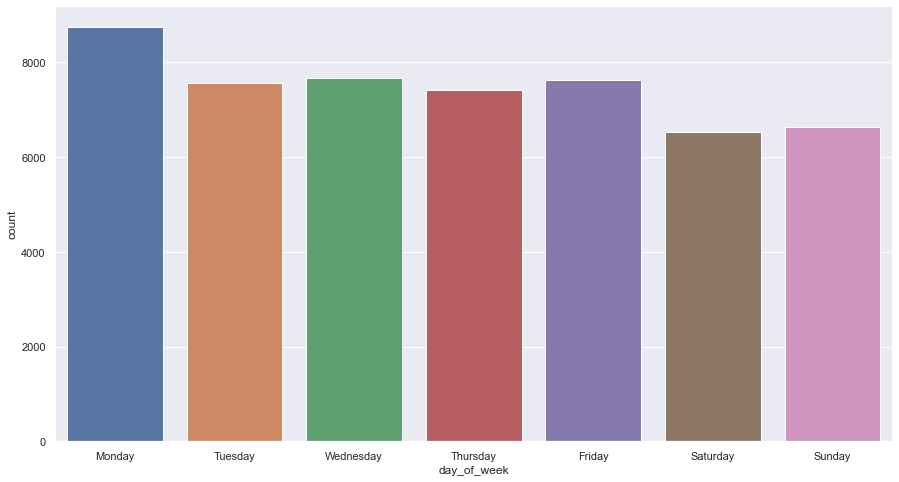

In [29]:
from pandas.api.types import CategoricalDtype
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_type = CategoricalDtype(categories=cats, ordered=True)
data['day_of_week'] = data['day_of_week'].astype(cat_type)
sns.set(rc = {'figure.figsize':(15,8)})
data_introd = data[data['categorie'] == 'Introduction']
sns.countplot(x="day_of_week", data=data_introd)

<AxesSubplot:xlabel='day_of_week', ylabel='count'>

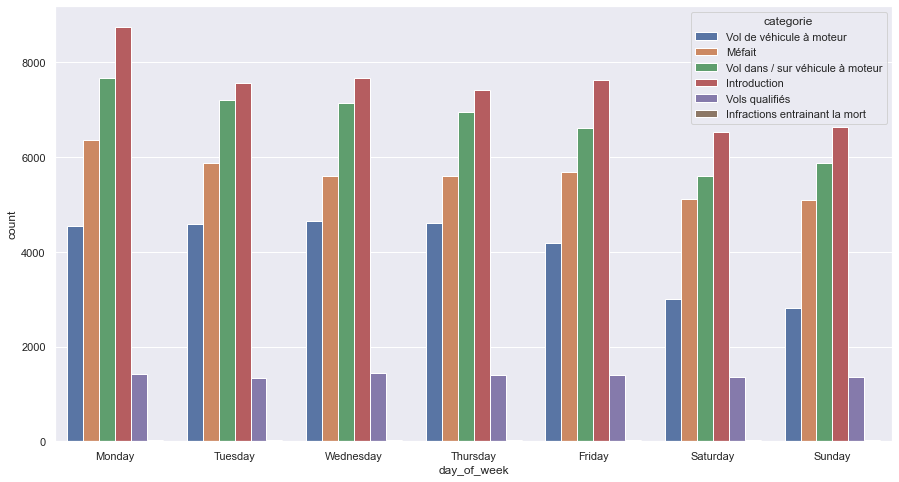

In [30]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x="day_of_week", hue="categorie", data=data)

In [ ]:
from shapely.geometry import Point, mapping, shape
for coord in data['geometry']:
    res = []
    mapping(coord)
    #{'type': 'Point', 'coordinates': (3.0, 4.0)}
    # and the reverse
    shape(mapping(coord))
    res.append(coord)
print(res)
res = pd.DataFrame(res)

In [ ]:
from keplergl import KeplerGl
map1 = KeplerGl(height=500)
map1
map1.add_data(data=data, name='Montreal\'s crime plot')

In [ ]:
map1.save_to_html(file_name='mtl_crime-customize.html')

In [ ]:
state = ox.geocode_to_gdf('Quebec, CA')
ax = ox.project_gdf(state).plot(fc='gray', ec='none')
_ = ax.axis('off')

In [ ]:
# Defining the map boundaries 
north, east, south, west = 45.6923, -73.3736, 45.3874, -73.9730  
# Downloading the map as a graph object 
G = ox.graph_from_bbox(north, south, east, west, network_type = 'drive')  
# Plotting the map graph 
ox.plot_graph(G)

In [ ]:
origin_point = (45.5173538,-73.58212888)
destination_point = (45.539385081961676,-73.54099988937377)
# get the nearest nodes to the locations 
origin_node = ox.get_nearest_node(G, origin_point) 
destination_node = ox.get_nearest_node(G, destination_point)
# Finding the optimal path 
route = nx.shortest_path(G, origin_node, destination_node, weight = 'length')
print(route)

In [ ]:
#store long, lat
long = [] 
lat = []  
for i in route:
     point = G.nodes[i]
     long.append(point['x'])
     lat.append(point['y'])

In [ ]:
#store long, lat
""""string = ""{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {
        "vendor":  "A"
      },
      "geometry": {
        "type": "LineString",
        "coordinates": [
          [-74.20986, 40.81773, 0],
          [-74.20987, 40.81765, 0],
          [-74.20998, 40.81746, 0]
        ]
      }
    }
  ]
}"""
first_string = "{\"type\": \"FeatureCollection\",\"features\": [{\"type\": \"Feature\",\"properties\": {\"vendor\":  \"A\"},\"geometry\": {\"type\": \"LineString\",\"coordinates\": [ "
coordinates = ""
long = [] 
lat = []  
for i in route: 
    point = G.nodes[i]
    print(point)
    long.append(point['x'])
    lat.append(point['y'])
    long_lat = "[" + str(point['x']) + "," + str(point['y']) + "],\n"
    coordinates += long_lat
final_string = "]}}]}"
string = first_string + coordinates + final_string
print(string)
print(len(route))
file2write=open("pathh",'w')
file2write.write(string)
file2write.close()

In [ ]:
def plot_path(lat, long, origin_point, destination_point):
  
    # adding the lines joining the nodes
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'purple')))
    # adding source marker
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
     
    # adding destination marker
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    
    # getting center for plots:
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    # defining the layout using mapbox_style
    fig.update_layout(mapbox_style="stamen-terrain",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                      mapbox = {
                          'center': {'lat': lat_center, 
                          'lon': long_center},
                          'zoom': 13})
    fig.show()

In [ ]:
plot_path(lat, long, origin_point, destination_point)